In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomCrop((32, 32), padding = 2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


def get_dataset(train_split = 0.9, transform=None):
    trainset = datasets.CIFAR10(root="/content", train=True, download=True, transform=test_transform)
    test_dataset = datasets.CIFAR10(root="/content", train=False, download=True, transform=test_transform)

    train_size = int(train_split * len(trainset))
    test_size = len(trainset) - train_size

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    for train_idx, val_idx in split.split(trainset, trainset.targets):
      train_dataset = Subset(trainset, train_idx)
      val_dataset = Subset(trainset, val_idx)

    train_dataset.dataset.transform = train_transform

    return train_dataset, val_dataset, test_dataset

# DataLoader

In [ ]:
import torch
def get_dataloader(train_dataset, val_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Utils

In [ ]:
import numpy as np
import random
from tqdm import tqdm

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
import os

def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [ ]:
import numpy as np
import random

import matplotlib.pyplot as plt
def plot_acc_loss(train_loss, train_acc, test_loss, test_acc):
  _, axes = plt.subplots(1, 2, figsize=(10, 4))
  plt.suptitle("Accuracy and  Loss plot for train and test data", size=14)
  train_acc = [x for x in train_acc]
  test_acc = [x for x in test_acc]
  axes[0].plot(list(range(1, len(train_acc)+1)), train_acc, 'navy',label='train accuracy')
  axes[0].plot(list(range(1, len(train_acc)+1)), test_acc, 'orange', label='test accuracy')
  axes[0].set_ylabel('Accuracy Average', size=12, labelpad=7)
  axes[0].set_xlabel('Epoch', size=12, labelpad=10)
  axes[0].legend(loc='lower right', fontsize=10)
  axes[0].grid()

  axes[1].plot(list(range(1, len(train_acc)+1)), train_loss, 'navy', label='train loss')
  axes[1].plot(list(range(1, len(train_acc)+1)), test_loss, 'orange',label='test loss')
  axes[1].set_ylabel('Loss Average', size=12, labelpad=5)
  axes[1].set_xlabel('Epoch', size=12, labelpad=10)
  axes[1].legend(loc='best', fontsize=10)
  axes[1].grid()

  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
def sample_from_dataset(dataset, sample_size, random_state=42):
    # Split the dataset into training and unused indices based on the sample size
    train_idx, _ = train_test_split(
        list(range(len(dataset))), train_size=sample_size, stratify=dataset.targets, random_state=random_state
    )

    # Create a subset of the dataset using the sampled indices
    train = Subset(dataset, train_idx)

    # Lists to store sampled data and their labels
    X_sampled = []
    y_sampled = []

    # Iterate through the subset to collect sampled data and labels
    for data, target in train:
        X_sampled.append(data)
        y_sampled.append(target)

    # Convert the lists to PyTorch tensors and stack them appropriately
    X_sampled = torch.stack(X_sampled, dim=0)
    y_sampled = torch.tensor(y_sampled).view(-1, 1)

    return X_sampled, y_sampled
def sample_from_CIFAR10(train_size, test_size):
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Load CIFAR10 training dataset
    dataset_train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=trans
    )

    # Load CIFAR10 test dataset
    dataset_test = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=trans
    )

    # Sample a subset of the training dataset based on the specified size
    X_train, y_train = sample_from_dataset(dataset_train, train_size)

    # Sample a subset of the test dataset based on the specified size
    X_test, y_test = sample_from_dataset(dataset_test, test_size)

    # Return the sampled training and test datasets
    return X_train, y_train, X_test, y_test


In [ ]:
def plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores):
  # plot SI history for train and test
  plt.figure(figsize=(12, 4))
  plt.plot(leaf_layers_names, train_layer_si_scores,'navy', label='Train')
  plt.plot(leaf_layers_names, test_layer_si_scores, 'orange' ,label='Test')

  plt.ylabel('SI')
  plt.xlabel('Layers')
  plt.xticks(rotation=85)
  plt.suptitle('SI History')
  plt.legend()
  plt.grid(axis='y', linestyle='-', linewidth=0.1)
  plt.show()

# SI

In [ ]:
def calculate_distance_matrix(feature_matrix):
    big_number = 1e10
    distance_matrix = torch.cdist(feature_matrix, feature_matrix, p=2).fill_diagonal_(big_number)
    return distance_matrix

def center_si(data, labels, n_class):
    n_feature = int(data.shape[1])
    label_feature_class = torch.arange(n_class, device=data.device).repeat([data.shape[0], n_feature, 1])
    label_feature_matrix = labels.unsqueeze(1).repeat([1, n_feature, n_class])
    label_comp = (label_feature_class == label_feature_matrix) * 1
    data_class = data.unsqueeze(2).repeat([1, 1, n_class])
    data_class_center = ((data_class * label_comp).sum(0) / label_comp.sum(0)).transpose(0, 1)
    dis_matrix = torch.cdist(data, data_class_center, p=2)
    values, label_neighb_center = torch.min(dis_matrix, 1)
    label_neighb_center = label_neighb_center.unsqueeze(1)
    csi = torch.sum(label_neighb_center == labels) / data.shape[0]
    return csi


def calc_center_si_score(inter_outputs, labels, layers_names):
    layers_center_si = []
    for layer_name in tqdm(layers_names):
        center_si_var = center_si(inter_outputs[layer_name], labels, 10)
        center_si_var = center_si_var.detach().cpu().numpy()
        layers_center_si.append(center_si_var)

    return layers_center_si

def separation_index(labels, distance_matrix):
    values, indices = torch.min(distance_matrix, 1)
    si_data = (labels[indices, :] == labels)
    si = torch.sum(si_data) / distance_matrix.shape[0]
    return si

def calc_si_score(inter_outputs, labels, layers_names):
    layers_si = []
    for layer_name in tqdm(layers_names):
        dist_matrix = calculate_distance_matrix(inter_outputs[layer_name])
        si_var = separation_index(labels, dist_matrix)
        si_var = si_var.detach().cpu().numpy()
        layers_si.append(si_var)

    return layers_si

from torchvision.models.feature_extraction import create_feature_extractor
def model_feature_extraction(layers_names , model, X_data):
    # extract all layers features
    nodes = {leaf: leaf for leaf in layers_names}
    extraction_model = create_feature_extractor(model, return_nodes=nodes)
    inter_outputs = extraction_model(X_data)

    # flat extracted features of each layer
    n_data = X_data.shape[0]
    for leaf in layers_names:
        inter_outputs[leaf] = inter_outputs[leaf].reshape(n_data, -1)

    return inter_outputs


def forward_feature_ranking_si(features, labels, device):
    num_data = features.shape[0]
    num_features = features.shape[1]

    selected_features = []
    scores = []
    remaining_features = set(range(num_features))

    loop_features = tqdm(range(num_features), total=num_features, desc="Features", position=0, leave=True)
    for forward_step in loop_features:
        best_feature = None
        best_si = -float('inf')

        for feature in remaining_features:
            current_features = selected_features + [feature]
            features_current = features[:, torch.tensor(current_features)]

            distance_matrix = calculate_distance_matrix(features_current)
            si = separation_index(labels, distance_matrix).item()

            if si > best_si:
                best_si = si
                best_feature = feature

        selected_features.append(best_feature)
        scores.append(best_si)
        remaining_features.remove(best_feature)
        print()
        loop_features.set_description(f"iteration : {forward_step + 1}")
        loop_features.set_postfix(
              Selected_Feature="{:d}".format(best_feature),
              Score="{:.4f}".format(best_si),
              refresh=True,
        )
        if best_si>=1:
          break
    print("Length of Final Selected Features:", len(selected_features))

    return selected_features, scores

# VGG-16

## without BN

In [ ]:
import torch
import torch.nn as nn

class VGG16(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.max1 = nn.MaxPool2d(2, stride=2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu4 = nn.ReLU(inplace=True)
        self.max2 = nn.MaxPool2d(2, stride=2)


        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu7 = nn.ReLU(inplace=True)
        self.max3 = nn.MaxPool2d(2, stride=2)


        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu8 = nn.ReLU(inplace=True)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu9 = nn.ReLU(inplace=True)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu10 = nn.ReLU(inplace=True)
        self.max4 = nn.MaxPool2d(2, stride=2)


        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu11 = nn.ReLU(inplace=True)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu12 = nn.ReLU(inplace=True)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu13 = nn.ReLU(inplace=True)
        self.max5 = nn.MaxPool2d(2, stride=2)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512, 4096)
        self.relu14 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.4)
        self.linear2 = nn.Linear(4096, 4096)
        self.relu15 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.4)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, input):
      x = self.conv1(input)

      x = self.relu1(x)
      x = self.conv2(x)

      x = self.relu2(x)
      x = self.max1(x)

      x = self.conv3(x)

      x = self.relu3(x)
      x = self.conv4(x)

      x = self.relu4(x)
      x = self.max2(x)

      x = self.conv5(x)

      x = self.relu5(x)
      x = self.conv6(x)

      x = self.relu6(x)
      x = self.conv7(x)

      x = self.relu7(x)
      x = self.max3(x)

      x = self.conv8(x)

      x = self.relu8(x)
      x = self.conv9(x)

      x = self.relu9(x)
      x = self.conv10(x)

      x = self.relu10(x)
      x = self.max4(x)

      x = self.conv11(x)
      x = self.relu11(x)
      x = self.conv12(x)
      x = self.relu12(x)
      x = self.conv13(x)
      x = self.relu13(x)
      x = self.max5(x)

      x = self.flatten(x)

      x = self.linear1(x)
      x = self.relu14(x)
      x = self.dropout1(x)
      x = self.linear2(x)
      x = self.relu15(x)
      x = self.dropout2(x)
      x = self.linear3(x)

      return x

In [ ]:
from torchsummary import summary
summary(VGG16().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,864
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,728
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         294,912
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         589,824
             ReLU-14            [-1, 25

## with BatchNorm

In [ ]:
import torch
import torch.nn as nn

class VGG16(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.max1 = nn.MaxPool2d(2, stride=2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace=True)
        self.max2 = nn.MaxPool2d(2, stride=2)


        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU(inplace=True)
        self.max3 = nn.MaxPool2d(2, stride=2)


        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU(inplace=True)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(512)
        self.relu9 = nn.ReLU(inplace=True)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(512)
        self.relu10 = nn.ReLU(inplace=True)
        self.max4 = nn.MaxPool2d(2, stride=2)


        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(512)
        self.relu11 = nn.ReLU(inplace=True)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn12 = nn.BatchNorm2d(512)
        self.relu12 = nn.ReLU(inplace=True)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn13 = nn.BatchNorm2d(512)
        self.relu13 = nn.ReLU(inplace=True)
        self.max5 = nn.MaxPool2d(2, stride=2)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512, 4096)
        self.relu14 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.4)
        self.linear2 = nn.Linear(4096, 4096)
        self.relu15 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.4)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, input):
      x = self.conv1(input)
      x = self.bn1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu2(x)
      x = self.max1(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x = self.relu3(x)
      x = self.conv4(x)
      x = self.bn4(x)
      x = self.relu4(x)
      x = self.max2(x)

      x = self.conv5(x)
      x = self.bn5(x)
      x = self.relu5(x)
      x = self.conv6(x)
      x = self.bn6(x)
      x = self.relu6(x)
      x = self.conv7(x)
      x = self.bn7(x)
      x = self.relu7(x)
      x = self.max3(x)

      x = self.conv8(x)
      x = self.bn8(x)
      x = self.relu8(x)
      x = self.conv9(x)
      x = self.bn9(x)
      x = self.relu9(x)
      x = self.conv10(x)
      x = self.bn10(x)
      x = self.relu10(x)
      x = self.max4(x)

      x = self.conv11(x)
      x = self.bn11(x)
      x = self.relu11(x)
      x = self.conv12(x)
      x = self.bn12(x)
      x = self.relu12(x)
      x = self.conv13(x)
      x = self.bn13(x)
      x = self.relu13(x)
      x = self.max5(x)

      x = self.flatten(x)

      x = self.linear1(x)
      x = self.relu14(x)
      x = self.dropout1(x)
      x = self.linear2(x)
      x = self.relu15(x)
      x = self.dropout2(x)
      x = self.linear3(x)

      return x

In [ ]:
from torchsummary import summary
summary(VGG16().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

## compressed Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG16Compressed(nn.Module):
    """
    Standard PyTorch implementation of VGG. Pretrained imagenet model is used.
    """
    def __init__(self, selected_features_ids, pretrained_vgg16):
        super().__init__()
        self.selected_features_ids = selected_features_ids
        children = list(dict(pretrained_vgg16.named_children()).keys())[:37]
        self.convs = nn.Sequential(*[getattr(pretrained_vgg16, name) for name in children])


        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(len(self.selected_features_ids), 4096)
        self.relu14 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.4)
        self.linear2 = nn.Linear(4096, 4096)
        self.relu15 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.4)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, input):
      x = self.convs(input)
      x = self.flatten(x)
      x = x[:, self.selected_features_ids]
      x = self.linear1(x)
      x = self.relu14(x)
      x = self.dropout1(x)
      x = self.linear2(x)
      x = self.relu15(x)
      x = self.dropout2(x)
      x = self.linear3(x)

      return x

#Fit

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

def fit(
    train_loader,
    val_loader,
    model,
    device,
    epochs,
    learning_rate,
    gamma,
    step_size,
    load_saved_model,
    saved_model_path,
    model_name
):

    all_train_acc = []
    all_train_loss = []
    all_val_acc = []
    all_val_loss = []
    model = model.to(device)

    report = pd.DataFrame(
      columns=[
          "model_name",
          "epoch",
          "avg_train_loss",
          "avg_train_acc",
          "avg_val_loss",
          "avg_val_acc"
  ])

    # loss function
    criterion = nn.CrossEntropyLoss()

    # optimzier
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

    lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0

        model.train()
        total = 0
        loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
        for idx, (images, labels) in loop_train:

            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            loss = criterion(preds, labels)
            train_loss+= loss.item()


            _, predicted = torch.max(preds.data, 1)
            train_acc+= (predicted == labels).sum().item()
            total+= labels.size(0)

            loss.backward()
            optimizer.step()

            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                train_accuracy="{:.4f}".format(train_acc * 100 / total),
                avg_train_loss="{:.4f}".format(train_loss / idx),
                refresh=True,
              )

        all_train_acc.append(train_acc *100 / total)
        all_train_loss.append(train_loss / len(train_loader))


        model.eval()
        total = 0
        with torch.no_grad():
            loop_val = tqdm(enumerate(val_loader, 1), total=len(val_loader), desc="val", position=0, leave=True)
            for idx, (images, labels) in loop_val:

                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                preds = model(images)

                loss = criterion(preds, labels)
                val_loss+= loss.item()

                _, predicted = torch.max(preds.data, 1)
                val_acc+= (predicted == labels).sum().item()
                total+= labels.size(0)

                loop_val.set_description(f"Val - iteration : {epoch}")
                loop_val.set_postfix(
                    val_accuracy="{:.4f}".format(val_acc * 100 / total),
                    avg_val_loss="{:.4f}".format(val_loss / idx),
                    refresh=True,
                )

        all_val_acc.append(val_acc *100 / total)
        all_val_loss.append(val_loss / len(val_loader))

        new_row = pd.DataFrame({
            "model_name": model_name,
            "epoch": epoch,
            "avg_train_acc": train_acc *100 / total,
            "avg_train_loss" : train_loss / len(train_loader),
            "avg_val_acc" : val_acc * 100 / total,
            "avg_val_loss" :val_loss / len(val_loader)
            },index=[0])

        report.loc[len(report)] = new_row.values[0]
        report.to_csv(f"/content/{model_name}_full.csv")

        if epoch % 20 == 0:
            save_model(
                file_path=saved_model_path,
                file_name=f"ckpt_compressed_vgg16_epoch{epoch}.ckpt",
                model=model,
                optimizer=optimizer,
            )

        lr_scheduler.step()
    return model, optimizer, all_train_acc, all_train_loss, all_val_acc, all_val_loss

# Test

In [ ]:
def test(model, val_loader, learning_rate, model_path, device):
    accuracy_ = []
    pred_ = []

    criterion = nn.CrossEntropyLoss()
    # optimzier
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    # loading model
    model, optimizer = load_model(
            ckpt_path=model_path, model=model, optimizer=optimizer)

    model.eval()
    model.to(device)
    total = 0
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        loop_test = tqdm(enumerate(val_loader, 1), total=len(val_loader), desc="Test", position=0, leave=True)
        for idx, (images, labels) in loop_test:
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            loss = criterion(preds, labels)
            test_loss+= loss.item()

            _, predicted = torch.max(preds.data, 1)
            test_acc+= (predicted == labels).sum().item()
            total+= labels.size(0)

            loop_test.set_description(f"Test")
            loop_test.set_postfix(
                train_accuracy="{:.4f}".format(test_acc * 100 / total),
                train_loss="{:.4f}".format(test_loss / idx),
                refresh=True,
            )

# Train

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

#A == > batchNorm
learning_rate = 1e-2
epochs = 50
batch_size = 128
gamma = 0.5
step_size = 15

In [ ]:
def main():
    set_seeds(0)

    train_dataset, val_dataset, test_dataset = get_dataset()
    train_loader, val_loader, test_loader = get_dataloader(train_dataset, val_dataset, test_dataset, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device: ", device)


    my_model = VGG16()

    model, optimizer, all_train_acc, all_train_loss, all_val_acc, all_val_loss = fit(
        train_loader=train_loader,
        val_loader=val_loader,
        model = my_model,
        epochs=epochs,
        learning_rate=learning_rate,
        gamma = gamma,
        step_size = step_size,
        device=device,
        load_saved_model=True,
        saved_model_path = "/content/freeze_checkpoints",
        model_name="vgg16"
    )
    plot_acc_loss(all_train_loss, all_train_acc, all_val_loss, all_val_acc)

    model_path = "/content/freeze_checkpoints/ckpt_freeze_vgg16_epoch20.ckpt"
    test(my_model, test_loader, learning_rate, model_path, device)

## With BN

mkdir: cannot create directory ‘/content/checkpoints’: File exists
Files already downloaded and verified
Files already downloaded and verified
device:  cuda


Val - iteration : 50: 100%|██████████| 40/40 [00:04<00:00,  9.87it/s, avg_val_loss=0.5172, val_accuracy=89.5600]


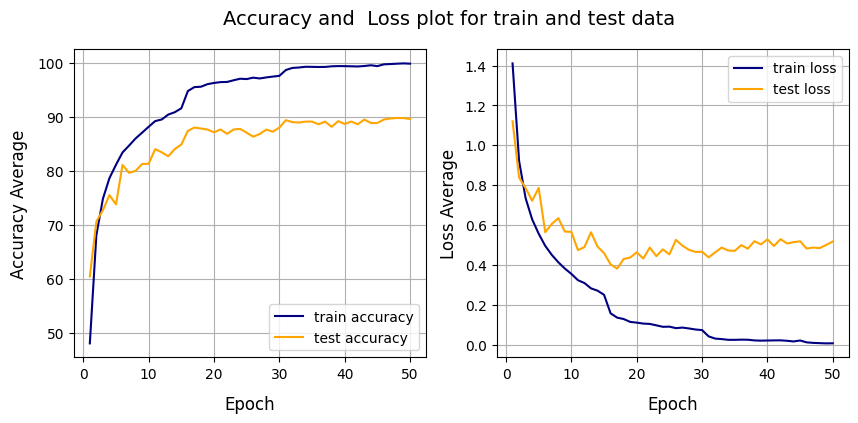

Test: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s, train_accuracy=90.1800, train_loss=0.4844]


In [ ]:
!mkdir '/content/checkpoints'
main()

In [ ]:
X_train_sampled, y_train_sampled, X_test_sampled, y_test_sampled = sample_from_CIFAR10(train_size=5000, test_size=5000)
X_train_sampled, y_train_sampled = X_train_sampled.to(device), y_train_sampled.to(device)
X_test_sampled, y_test_sampled = X_test_sampled.to(device), y_test_sampled.to(device)

Files already downloaded and verified
Files already downloaded and verified


### center si

100%|██████████| 52/52 [00:01<00:00, 32.57it/s]


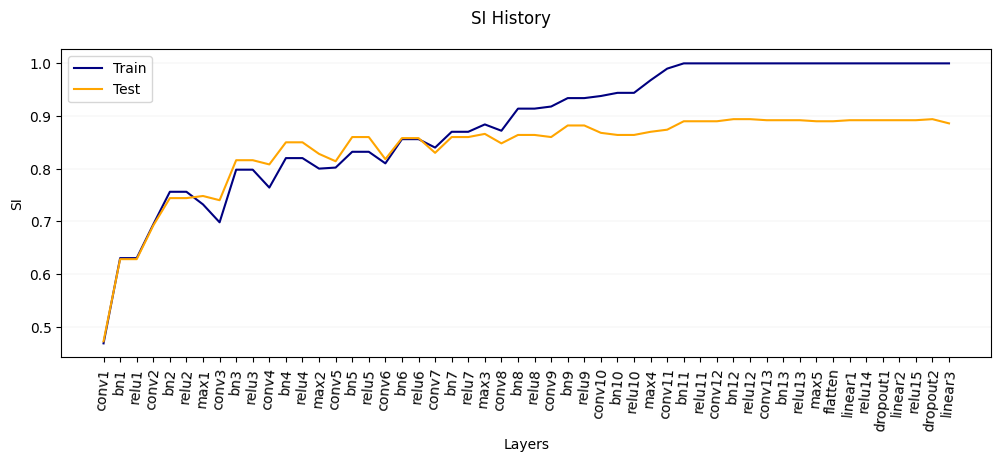

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

my_model= VGG16()
leaf_layers_names = list(dict(my_model.named_children()).keys())
model, optimizer = load_model(ckpt_path="/content/BN_checkpoints/ckpt_vgg16_epoch50.ckpt", model=my_model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
# train_intermediate_outputs['max4'].shape
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_center_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_center_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

## without BN

mkdir: cannot create directory ‘/content/checkpoints’: File exists
Files already downloaded and verified
Files already downloaded and verified
device:  cuda


Val - iteration : 200: 100%|██████████| 40/40 [00:05<00:00,  7.15it/s, avg_val_loss=0.7380, val_accuracy=86.6200]


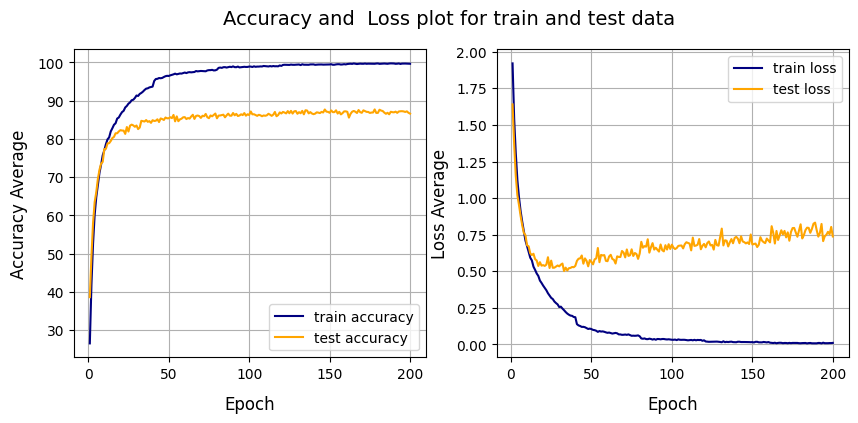

Test: 100%|██████████| 79/79 [00:05<00:00, 14.47it/s, train_accuracy=87.6800, train_loss=0.7018]


In [ ]:
!mkdir '/content/checkpoints'
main()

In [ ]:
X_train_sampled, y_train_sampled, X_test_sampled, y_test_sampled = sample_from_CIFAR10(train_size=5000, test_size=5000)
X_train_sampled, y_train_sampled = X_train_sampled.to(device), y_train_sampled.to(device)
X_test_sampled, y_test_sampled = X_test_sampled.to(device), y_test_sampled.to(device)

Files already downloaded and verified
Files already downloaded and verified


### Center SI

100%|██████████| 39/39 [00:01<00:00, 35.52it/s]


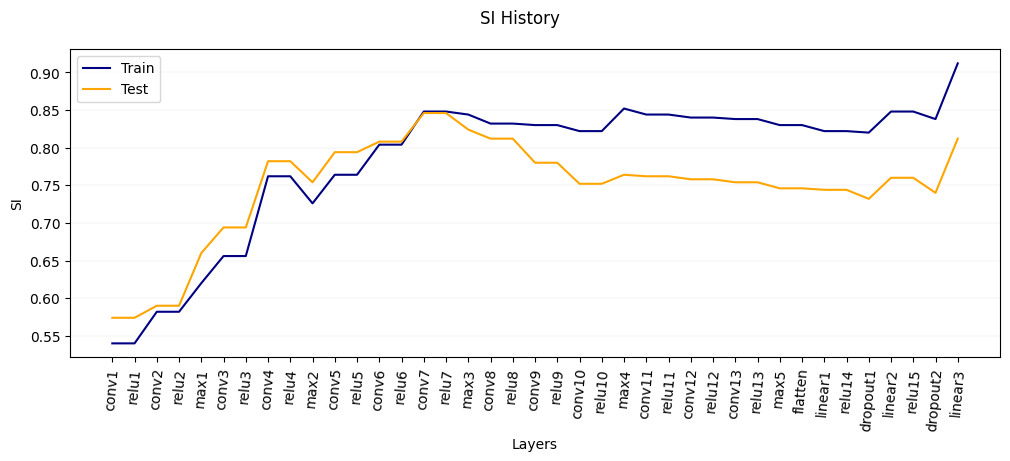

In [ ]:
from tqdm import tqdm

my_model= VGG16()
leaf_layers_names = list(dict(my_model.named_children()).keys())
model, optimizer = load_model(ckpt_path="/content/checkpoints/ckpt_vgg16_epoch200.ckpt", model=my_model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
# train_intermediate_outputs['max4'].shape
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_center_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_center_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

### SI

100%|██████████| 39/39 [00:00<00:00, 269.76it/s]


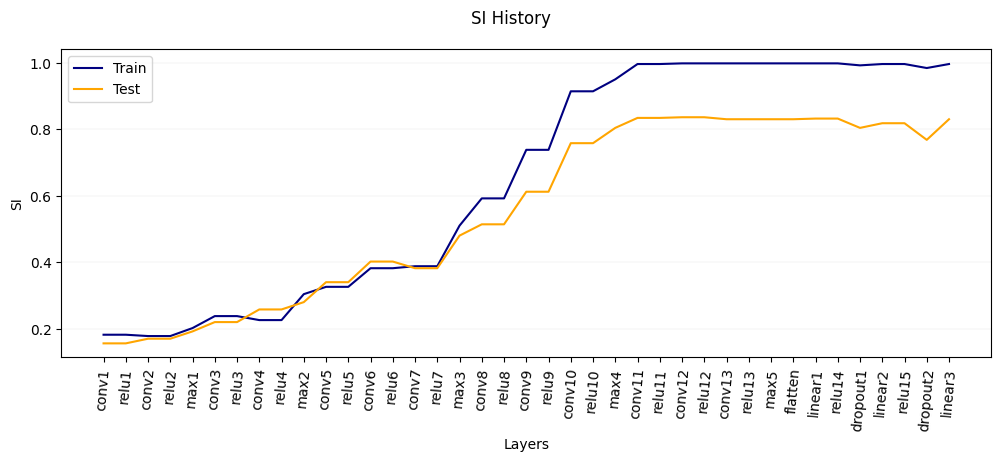

In [ ]:
my_model= VGG16()
leaf_layers_names = list(dict(my_model.named_children()).keys())
model, optimizer = load_model(ckpt_path="/content/checkpoints/ckpt_vgg16_epoch200.ckpt", model=my_model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
# train_intermediate_outputs['max4'].shape
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

# B) Freeze Model

In [ ]:
#B
learning_rate = 1e-3
epochs = 20
batch_size = 128
gamma = 0.1
step_size = 8

Files already downloaded and verified
Files already downloaded and verified
device:  cuda


Val - iteration : 20: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s, avg_val_loss=0.5229, val_accuracy=89.6200]


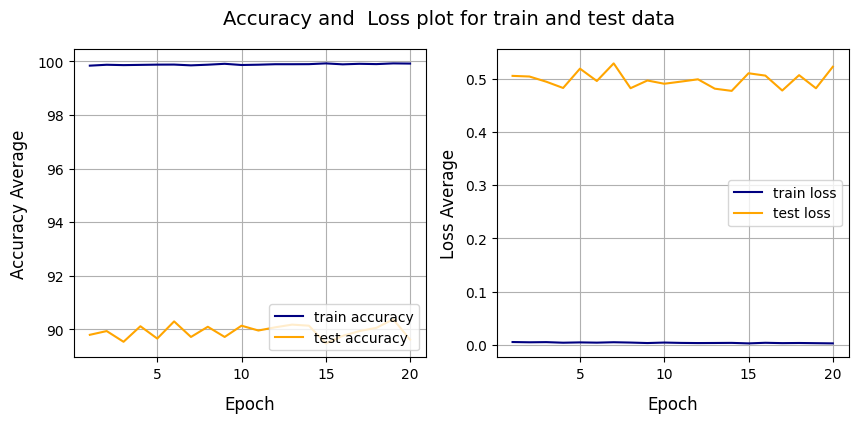

FileNotFoundError: [Errno 2] No such file or directory: '/content/freeze_checkpoints/ckpt_vgg16_epoch20.ckpt'

In [ ]:
# !mkdir '/content/freeze_checkpoints'
main()

In [ ]:
main()

Files already downloaded and verified
Files already downloaded and verified
device:  cuda


Test: 100%|██████████| 79/79 [00:05<00:00, 15.26it/s, train_accuracy=90.2800, train_loss=0.4927]


100%|██████████| 52/52 [00:01<00:00, 35.00it/s]


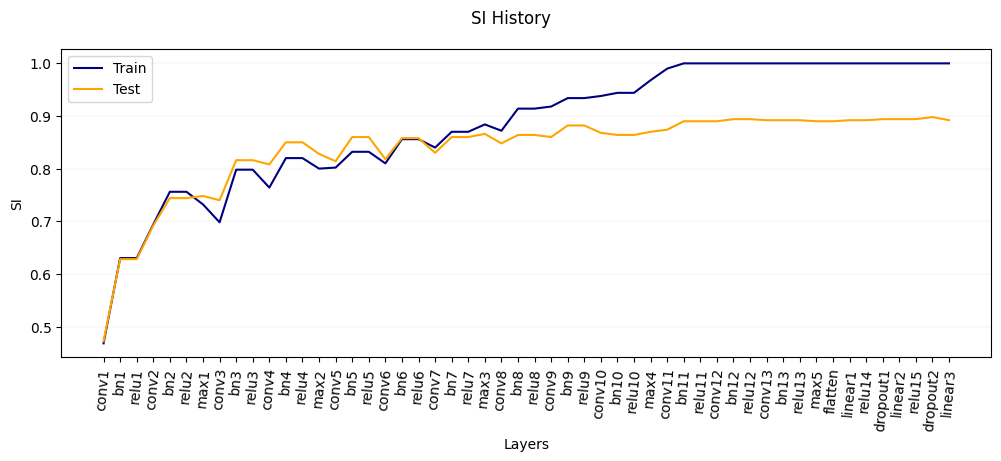

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

my_model= VGG16()
leaf_layers_names = list(dict(my_model.named_children()).keys())
model, optimizer = load_model(ckpt_path="/content/freeze_checkpoints/ckpt_freeze_vgg16_epoch20.ckpt", model=my_model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_center_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_center_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

# C) Feature Selection

In [ ]:
X_train_sampled, y_train_sampled, X_test_sampled, y_test_sampled = sample_from_CIFAR10(train_size=5000, test_size=5000)
X_train_sampled, y_train_sampled = X_train_sampled.to(device), y_train_sampled.to(device)
X_test_sampled, y_test_sampled = X_test_sampled.to(device), y_test_sampled.to(device)

Files already downloaded and verified
Files already downloaded and verified


## A) SI plot

100%|██████████| 52/52 [00:00<00:00, 79.44it/s]


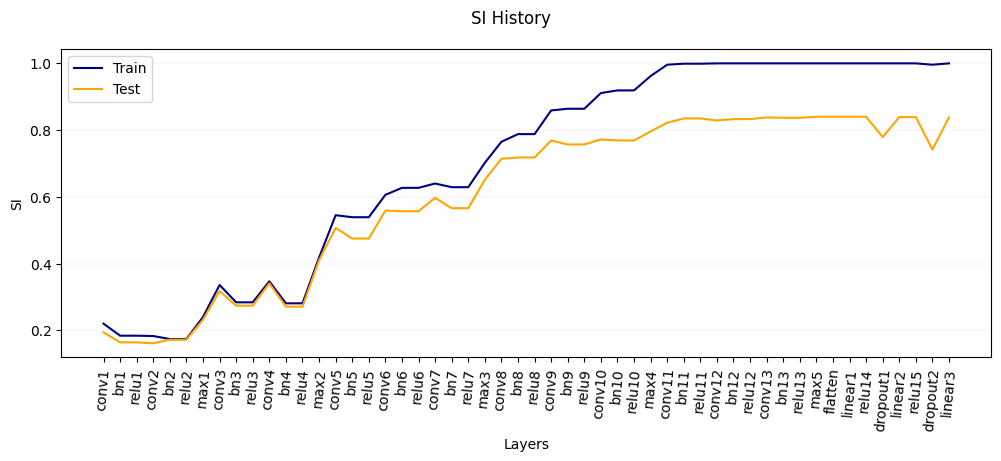

In [ ]:
my_model= VGG16()
leaf_layers_names = list(dict(my_model.named_children()).keys())
model, optimizer = load_model(ckpt_path="/content/BN_checkpoints/ckpt_vgg16_epoch50.ckpt", model=my_model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

##B) feature selection

In [ ]:
model= VGG16()
leaf_layers_names = ['relu11']
model, optimizer = load_model(ckpt_path="/content/BN_checkpoints/ckpt_vgg16_epoch50.ckpt", model=model, optimizer=None)
model = model.to(device)

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)

In [ ]:
train_intermediate_outputs['relu11'].shape

torch.Size([5000, 2048])

In [ ]:
best_features, scores = forward_feature_ranking_si(train_intermediate_outputs['relu11'].to(device),
                                                                   y_train_sampled.to(device),
                                                                   device)

iteration : 1:   0%|          | 1/2048 [00:06<3:35:25,  6.31s/it, Score=0.2870, Selected_Feature=436]

iteration : 2:   0%|          | 2/2048 [00:12<3:26:48,  6.06s/it, Score=0.4858, Selected_Feature=1420]

iteration : 3:   0%|          | 3/2048 [00:18<3:25:06,  6.02s/it, Score=0.7178, Selected_Feature=346]

iteration : 4:   0%|          | 4/2048 [00:24<3:23:52,  5.98s/it, Score=0.8520, Selected_Feature=1769]

iteration : 5:   0%|          | 5/2048 [00:29<3:21:55,  5.93s/it, Score=0.9052, Selected_Feature=901]

iteration : 6:   0%|          | 6/2048 [00:35<3:22:56,  5.96s/it, Score=0.9440, Selected_Feature=1908]

iteration : 7:   0%|          | 7/2048 [00:41<3:22:01,  5.94s/it, Score=0.9608, Selected_Feature=821]

iteration : 8:   0%|          | 8/2048 [00:47<3:22:34,  5.96s/it, Score=0.9732, Selected_Feature=927]

iteration : 9:   0%|          | 9/2048 [00:53<3:22:23,  5.96s/it, Score=0.9802, Selected_Feature=1794]

iteration : 10:   0%|          | 10/2048 [01:00<3:29:22,  6.16s/it, Score=0.9854, Selected_Feature=1686]

iteration : 11:   1%|          | 11/2048 [01:06<3:28:14,  6.13s/it, Score=0.9886, Selected_Feature=1373]

iteration : 12:   1%|          | 12/2048 [01:12<3:25:33,  6.06s/it, Score=0.9922, Selected_Feature=1808]

iteration : 13:   1%|          | 13/2048 [01:19<3:33:14,  6.29s/it, Score=0.9936, Selected_Feature=22]

iteration : 14:   1%|          | 14/2048 [01:25<3:35:02,  6.34s/it, Score=0.9950, Selected_Feature=35]

iteration : 15:   1%|          | 15/2048 [01:31<3:31:26,  6.24s/it, Score=0.9956, Selected_Feature=59]

iteration : 16:   1%|          | 16/2048 [01:37<3:28:31,  6.16s/it, Score=0.9962, Selected_Feature=458]

iteration : 17:   1%|          | 17/2048 [01:43<3:25:26,  6.07s/it, Score=0.9968, Selected_Feature=1122]

iteration : 18:   1%|          | 18/2048 [01:49<3:24:57,  6.06s/it, Score=0.9974, Selected_Feature=558]

iteration : 19:   1%|          | 19/2048 [01:55<3:22:40,  5.99s/it, Score=0.9978, Selected_Feature=217]

iteration : 20:   1%|          | 20/2048 [02:01<3:22:14,  5.98s/it, Score=0.9982, Selected_Feature=853]

iteration : 21:   1%|          | 21/2048 [02:07<3:21:35,  5.97s/it, Score=0.9986, Selected_Feature=528]

iteration : 22:   1%|          | 22/2048 [02:13<3:21:13,  5.96s/it, Score=0.9988, Selected_Feature=579]

iteration : 23:   1%|          | 23/2048 [02:19<3:22:42,  6.01s/it, Score=0.9994, Selected_Feature=1762]

iteration : 24:   1%|          | 24/2048 [02:25<3:22:14,  6.00s/it, Score=0.9998, Selected_Feature=1641]

iteration : 25:   1%|          | 24/2048 [02:31<3:32:47,  6.31s/it, Score=1.0000, Selected_Feature=111]


Length of Final Selected Features: 25


In [ ]:
best_features

[436,
 1420,
 346,
 1769,
 901,
 1908,
 821,
 927,
 1794,
 1686,
 1373,
 1808,
 22,
 35,
 59,
 458,
 1122,
 558,
 217,
 853,
 528,
 579,
 1762,
 1641,
 111]

#### si plot of all features

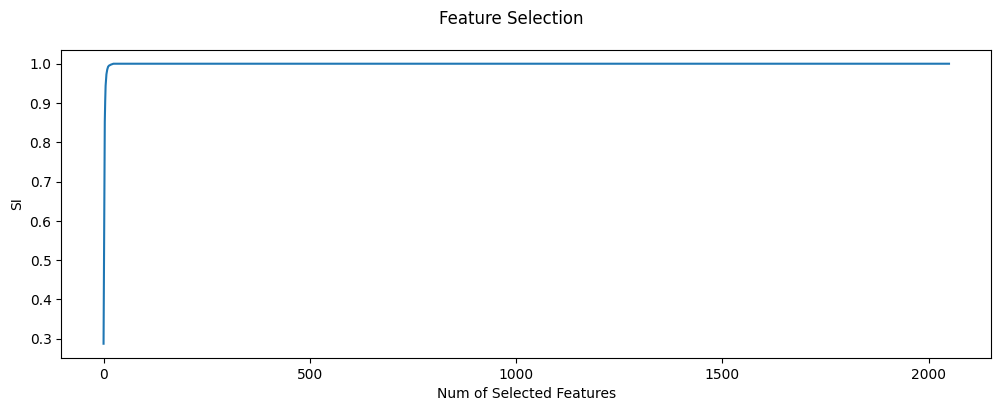

In [ ]:
# plot SI history during feature selection algorithm
plt.figure(figsize=(12, 4))
plt.plot(all_scores)
plt.ylabel('SI')
plt.xlabel('Num of Selected Features')
plt.suptitle('Feature Selection')
plt.show()

#### si plot of best features

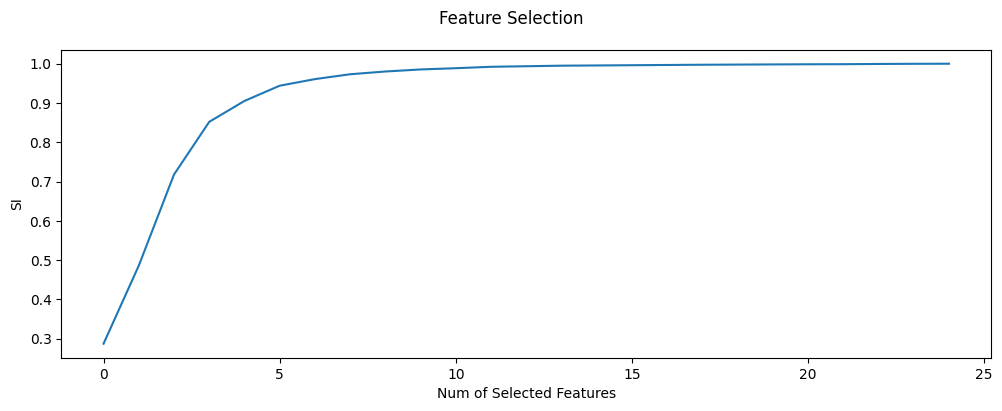

In [ ]:
# plot SI history during feature selection algorithm
plt.figure(figsize=(12, 4))
plt.plot(scores)
plt.ylabel('SI')
plt.xlabel('Num of Selected Features')
plt.suptitle('Feature Selection')
plt.show()

## C) Train Model

In [ ]:
def main():
    set_seeds(0)

    train_dataset, val_dataset, test_dataset = get_dataset()
    train_loader, val_loader, test_loader = get_dataloader(train_dataset, val_dataset, test_dataset, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device: ", device)

    model = VGG16()
    model, optimizer = load_model(
        ckpt_path="/content/BN_checkpoints/ckpt_vgg16_epoch50.ckpt", model=model, optimizer=None
    )

    for param in model.parameters():
        param.requires_grad = False
    for param in model.linear1.parameters():
        param.requires_grad = True
    for param in model.dropout1.parameters():
        param.requires_grad = True
    for param in model.relu14.parameters():
        param.requires_grad = True
    for param in model.linear2.parameters():
        param.requires_grad = True
    for param in model.relu15.parameters():
        param.requires_grad = True
    for param in model.dropout2.parameters():
        param.requires_grad = True
    for param in model.linear3.parameters():
        param.requires_grad = True

    my_model = VGG16Compressed(best_features, model)

    model, optimizer, all_train_acc, all_train_loss, all_val_acc, all_val_loss = fit(
        train_loader=train_loader,
        val_loader=val_loader,
        model = my_model,
        epochs=epochs,
        learning_rate=learning_rate,
        gamma = gamma,
        step_size = step_size,
        device=device,
        load_saved_model=True,
        saved_model_path = "/content/compressed_checkpoints",
        model_name="vgg16"
    )
    plot_acc_loss(all_train_loss, all_train_acc, all_val_loss, all_val_acc)

    model_path = "/content/compressed_checkpoints/ckpt_compressed_vgg16_epoch20.ckpt"
    test(my_model, test_loader, learning_rate, model_path, device)

In [ ]:
learning_rate = 1e-3
epochs = 20
batch_size = 128
gamma = 0.1
step_size = 8

Files already downloaded and verified
Files already downloaded and verified
device:  cuda


Val - iteration : 20: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s, avg_val_loss=0.4044, val_accuracy=88.6600]


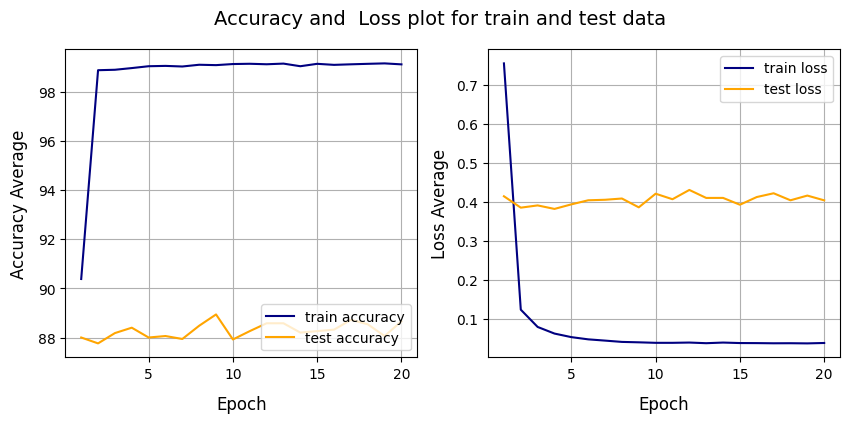

Test: 100%|██████████| 79/79 [00:05<00:00, 15.17it/s, train_accuracy=89.0700, train_loss=0.3982]


In [ ]:
# !mkdir '/content/compressed_checkpoints'
main()

In [ ]:
X_train_sampled, y_train_sampled, X_test_sampled, y_test_sampled = sample_from_CIFAR10(train_size=5000, test_size=5000)
X_train_sampled, y_train_sampled = X_train_sampled.to(device), y_train_sampled.to(device)
X_test_sampled, y_test_sampled = X_test_sampled.to(device), y_test_sampled.to(device)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 44/44 [00:01<00:00, 27.71it/s]


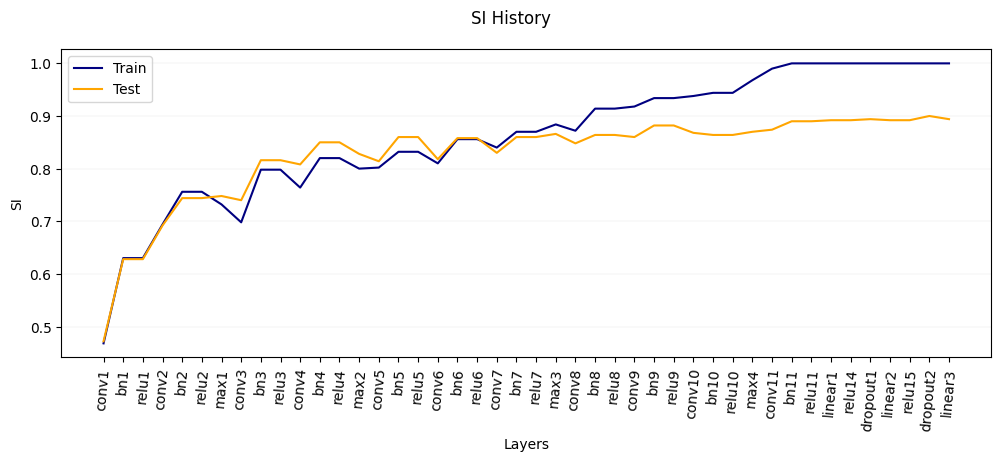

In [ ]:
model= VGG16()
my_model = VGG16Compressed(best_features, model)
model = model.to(device)
model, optimizer = load_model(
      ckpt_path="/content/compressed_checkpoints/ckpt_vgg16_epoch20.ckpt", model=model, optimizer=None
    )
leaf_layers_names = list(dict(model.named_children()).keys())

# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(leaf_layers_names, model, X_train_sampled)
# train_intermediate_outputs['max4'].shape
test_intermediate_outputs = model_feature_extraction(leaf_layers_names , model, X_test_sampled)

# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_center_si_score(train_intermediate_outputs, y_train_sampled, leaf_layers_names)
test_layer_si_scores = calc_center_si_score(test_intermediate_outputs, y_test_sampled, leaf_layers_names)

plot_si(leaf_layers_names, train_layer_si_scores, test_layer_si_scores)

### Trainable parameters

#### main model

In [ ]:
from torchsummary import summary
model = VGG16().to(device)
summary(model, [(3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

#### compressed Model

In [ ]:
from torchsummary import summary
summary(VGG16Compressed(best_features, model).to(device), [(3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

# Save Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/freeze_checkpoints' '/content/drive/MyDrive/AADNN/HW#4'
!cp -r '/content/freeze_vgg16_full.csv' '/content/drive/MyDrive/AADNN/HW#4'

In [ ]:
!cp -r '/content/drive/MyDrive/AADNN/HW#4/BN_checkpoints/' '/content'

In [ ]:
!cp -r '/content/drive/MyDrive/AADNN/HW#4/checkpoints' '/content'